# Deconstruct - Single Event and Multiple Event

In [10]:
# Import lib
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
import re


In [11]:
# Read the data function
# Reading the stats which was created in the Snakemake pipeline
def read_data(filename): 
    data = []
    with open(filename) as file: 
        for line in file.readlines(): 
            if not line.startswith("#"): 
                ls = line.split()
                data.append([ls[0], ls[1], ls[2], ls[3:]])
    return data

In [ ]:
# Read all data - takes some time to run 
d = [1,2,3,4,5]
data = []
for x in d: 
    print(x)
    data.append(read_data("../results/deconstruct/stats/chr"+ str(x)+"_Chr"+str(x)+".stats"))

1
2
3
4
5


In [126]:
# Check the data
print(len(data[0][0][3]))
print(data[0][0][3])



28
['1', '.', '0', '0', '.', '.', '0', '0', '.', '.', '.', '0', '.', '.', '.', '0', '0', '0', '0', '0', '0', '0', '0', '.', '0', '0', '0', '0']


In [124]:
for x in data[4]: 
    f = True
    for y in x[3]:
        if x[3][0] != y: 
            f = False
            
    if f: 
        print(x)

# SV definition
- One "allele" is >= 15 bp
## Single event definition: 
    1. 0.05*(maxLen) in Size
    2. maxLen but similar to all other maxLen structure (you need the graph for this)
    3. All accession the graph were built with, must be part of the bubble (count(accession) == max_accession)

## Multi event definition: 
- Everything what is not SE

# Read the graph

In [28]:
# Reading the graph with sequence and path
def readGFA(file):
    nodes = dict()
    paths = dict()
    with open(file) as file: 
        for x in file.readlines(): 
            if x.startswith("S"): 
                l = x.split()
                nodes[l[1]] = l[2]
            elif x.startswith("P"): 
                l = x.split()
                paths[l[1]] = [x for x in l[2].split(",")]
    return nodes, paths

In [17]:
nodes = []
paths = []
d = [1,2,3,4,5]

# Do this for all graphs
# Save nodes and paths in different lists
for x in d: 
    n1, p1 = readGFA("/ebio/abt6_projects9/1001g_plus_pan/data/graphs/ath_20230726/data/chr" + str(x) + ".90/chr" + str(x) + ".fasta.gz.4158095.c2fac19.5c75112.smooth.final.gfa")
    nodes.append(n1)
    paths.append(p1)

# SVs

In [29]:
# Filter all files to get all bubbles that te

all_svs = []
for x in range(5): 
    svs = []
    for v in data[x]: 
        lengths = [int(x) for x in v[2].split(",")]
        if max(lengths) >= 15: 
            svs.append(v)
    all_svs.append(svs)

In [32]:
len(all_svs[1])

27436

In [33]:
# Get the length if a specific node list
def getLen(d, nodes): 
    ll = 0
    for x in d:
        ll += len(nodes[x])
    return ll

In [164]:
# Check for SingleEvent SVs

def detect_SE_SVs(allsvs, nodes): 
    result = []
    
    
    for i, svs in enumerate(allsvs): 
        print("Chromosome ", i+1)
        indels = []
        indels2 = []
        
        c = 0 
        cc = 0
        
        # Tage the right graph
        chr_nodes = nodes[i]
        
        
        for v in svs: 
            # Check if all accessions have this bubble
            if len(v[3]) == len([x for x in v[3] if x.isnumeric()]):
                
                # This is the length
                lengths = [int(x) for x in v[2].split(",")]
                # Get max length
                mm = max(lengths)
                
                # Check the first thing. Is the traversal small (smaller than 0.05*max_size, or big?)
                # big = the all traversals, vv = index 
                big = []
                vv = []
                small = False
                for i, x in enumerate(v[1].split(",")): 
                    if lengths[i] > 0.05*mm:
                        big.append(x)
                        vv.append(str(i))
                    else: 
                        small = True
                if small: 
                    # take first traversal split by first non-numeric letter
                    f1 = re.split(r'\D+',big[0][1:])
                    # Remove first and last entry
                    un = set(f1[1:-1])
                    # Do this with the rest
                    for x in big[1:]: 
                        f1 = re.split(r'\D+',x[1:])
                        un = un.intersection(set(f1[1:-1]))

                    if len(un) != 0: 

                        # Combine all nodes in this set 
                        o = 1
                        for x in big:
                            f1 = re.split(r'\D+',x[1:])
                            f1_set = set(f1[1:-1])
                            f1_diff = f1_set-un
                            if len(f1_diff) == 0: 
                                o = 1
                            else: 
                                o = min(o, getLen(f1_diff, chr_nodes)/getLen(un, chr_nodes))


                        if o > 0.9: 
                            c += 1
                            indels.append(v)
                            df = 0
                            for x in v[3]: 
                                if x in vv:
                                    df += 1
                            if df == 28: 
                                print(v)
                                print(vv)
                                print()
                            indels2.append([df, mm])
            if cc % 10000 == 0:
                print(cc)
                print(c)
            cc += 1

        result.append(indels2)
        print("t")

    return result
            

In [165]:
len(all_svs[4])

34020

In [166]:
f = detect_SE_SVs(all_svs, nodes)

Chromosome  1
0
0
10000
2562
20000
3511
30000
5318
t
Chromosome  2
0
0
10000
652
20000
3113
t
Chromosome  3
0
0
10000
2342
20000
2851
30000
4172
t
Chromosome  4
0
0
10000
919
20000
3224
t
Chromosome  5
0
0
10000
2262
20000
3160
30000
5277
t


In [167]:
f

[[[27, 24],
  [1, 3370],
  [2, 23],
  [14, 54],
  [1, 29],
  [27, 32],
  [1, 19],
  [1, 17],
  [22, 16],
  [1, 276],
  [9, 24],
  [1, 3397],
  [27, 19],
  [26, 22],
  [6, 21],
  [16, 30],
  [8, 17],
  [8, 21],
  [4, 17],
  [17, 20],
  [22, 42],
  [23, 35],
  [1, 395],
  [27, 18],
  [1, 15],
  [21, 33],
  [26, 15],
  [4, 23],
  [27, 15],
  [12, 15],
  [16, 60],
  [1, 28],
  [2, 55],
  [2, 15],
  [14, 22],
  [13, 18],
  [1, 22],
  [27, 15],
  [1, 3681],
  [1, 5630],
  [1, 19],
  [19, 20],
  [15, 15],
  [16, 22],
  [1, 28],
  [22, 22],
  [15, 38],
  [27, 16],
  [27, 18],
  [1, 30],
  [27, 17],
  [3, 15],
  [27, 27],
  [2, 33],
  [14, 41],
  [10, 1159],
  [1, 546],
  [26, 24],
  [1, 32],
  [24, 31],
  [27, 53],
  [22, 22],
  [1, 1091],
  [24, 17],
  [21, 21],
  [3, 298],
  [10, 15],
  [27, 21],
  [1, 2084],
  [27, 21],
  [2, 50],
  [25, 71],
  [5, 47],
  [27, 17],
  [25, 26],
  [27, 32],
  [1, 7715],
  [26, 15],
  [7, 88],
  [27, 15],
  [27, 18],
  [1, 33],
  [27, 18],
  [15, 91],
  [27, 1

In [208]:
len(all_svs[3])

26905

In [209]:
len(f[2])

4172

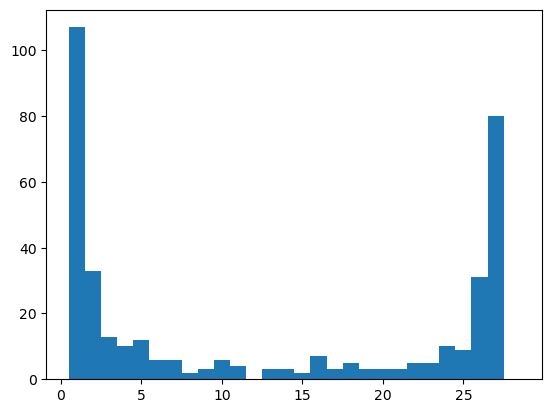

In [210]:
plt.hist([x[0] for x in f[0] if x[1] > 50 and x[1] < 100], bins = np.linspace(0.5,28.5, 29))
plt.show()

In [211]:
result = []
for x in range(1,28): 
    print(x)
    result_help = []
    for x1 in f: 
        for y in x1:
            if y[0] == x: 
                result_help.append(y[1])
    result.append(result_help)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [212]:
helper = []
for x in result: 
    helper.append(np.histogram(x, bins = [0, 50, 100, 200, 500, 1000, 2000, 5000, 100000000]))

In [213]:
helper2 = np.array([x[0] for x in helper])
helper2

array([[2938,  413,  244,  320,  370,  531,  951,  752],
       [1270,  145,   54,   57,   42,   73,   71,   60],
       [ 657,   66,   26,   18,   17,    9,   16,   14],
       [ 503,   43,   19,   13,    5,    3,    4,    6],
       [ 410,   36,   13,    5,    3,    5,    2,    5],
       [ 323,   29,    7,    2,    1,    2,    4,    3],
       [ 279,   25,    7,    4,    3,    2,    6,    2],
       [ 253,   23,    4,    2,    4,    2,    2,    7],
       [ 214,   19,    2,    3,    0,    1,    4,    2],
       [ 239,   22,    4,    1,    2,    1,    1,    7],
       [ 194,   12,    8,    1,    5,    2,    2,    3],
       [ 200,   14,    4,    3,    1,    1,    2,    2],
       [ 181,   13,    2,    3,    0,    0,    0,    2],
       [ 191,    9,    3,    0,    1,    0,    1,    0],
       [ 210,   17,    1,    0,    0,    0,    2,    0],
       [ 193,   19,    3,    1,    0,    1,    1,    5],
       [ 189,   15,    3,    2,    0,    2,    0,    2],
       [ 215,   15,    1,    0,

In [214]:
df = pd.DataFrame(helper2)

In [230]:
df2 = df.div(df.sum(axis=1), axis=0)

In [236]:
df2

,15-50,50-100,100-200,200-500,500-1000,1000-2000,2000-5000,5000-inf
0,0.450683,0.063353,0.037429,0.049087,0.056757,0.081454,0.145881,0.115355
1,0.716704,0.081828,0.030474,0.032167,0.023702,0.041196,0.040068,0.033860
2,0.798299,0.080194,0.031592,0.021871,0.020656,0.010936,0.019441,0.017011
3,0.843960,0.072148,0.031879,0.021812,0.008389,0.005034,0.006711,0.010067
4,0.855950,0.075157,0.027140,0.010438,0.006263,0.010438,0.004175,0.010438
5,0.870620,0.078167,0.018868,0.005391,0.002695,0.005391,0.010782,0.008086
6,0.850610,0.076220,0.021341,0.012195,0.009146,0.006098,0.018293,0.006098
7,0.851852,0.077441,0.013468,0.006734,0.013468,0.006734,0.006734,0.023569
8,0.873469,0.077551,0.008163,0.012245,0.000000,0.004082,0.016327,0.008163
9,0.862816,0.079422,0.014440,0.003610,0.007220,0.003610,0.003610,0.025271


In [231]:
df.columns = ["15-50", "50-100", "100-200", "200-500", "500-1000", "1000-2000", "2000-5000", "5000-inf"]
df2.columns = ["15-50", "50-100", "100-200", "200-500", "500-1000", "1000-2000", "2000-5000", "5000-inf"]

In [232]:
#football[football.columns[::-1]]

In [233]:
df2

,15-50,50-100,100-200,200-500,500-1000,1000-2000,2000-5000,5000-inf
0,0.450683,0.063353,0.037429,0.049087,0.056757,0.081454,0.145881,0.115355
1,0.716704,0.081828,0.030474,0.032167,0.023702,0.041196,0.040068,0.033860
2,0.798299,0.080194,0.031592,0.021871,0.020656,0.010936,0.019441,0.017011
3,0.843960,0.072148,0.031879,0.021812,0.008389,0.005034,0.006711,0.010067
4,0.855950,0.075157,0.027140,0.010438,0.006263,0.010438,0.004175,0.010438
5,0.870620,0.078167,0.018868,0.005391,0.002695,0.005391,0.010782,0.008086
6,0.850610,0.076220,0.021341,0.012195,0.009146,0.006098,0.018293,0.006098
7,0.851852,0.077441,0.013468,0.006734,0.013468,0.006734,0.006734,0.023569
8,0.873469,0.077551,0.008163,0.012245,0.000000,0.004082,0.016327,0.008163
9,0.862816,0.079422,0.014440,0.003610,0.007220,0.003610,0.003610,0.025271


<Figure size 2000x1000 with 0 Axes>

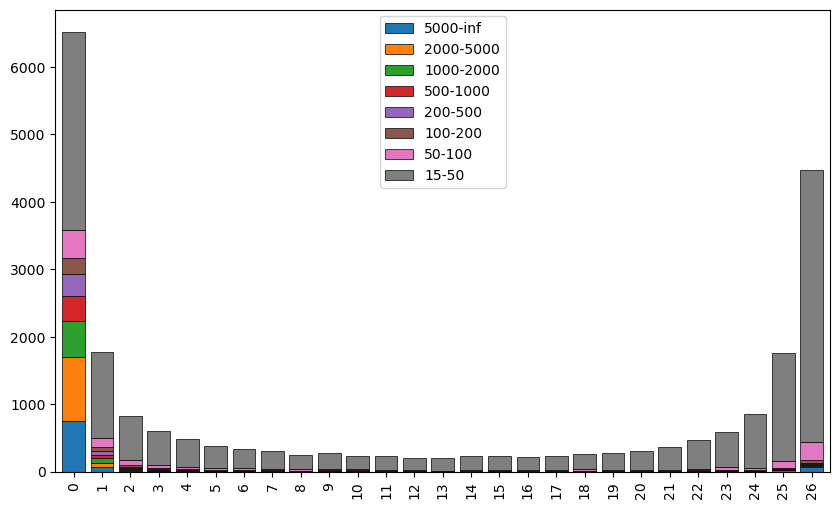

In [219]:
plt.rcParams['font.size'] = 10

plt.figure(figsize = (20,10))
df[df.columns[::-1]].plot.bar(stacked = True, width = 0.8, edgecolor = "black", linewidth = 0.5, figsize = (10,6), legend = True)
plt.savefig("plots/sizes_absolute.png", dpi = 1000)
plt.show()

<Figure size 2000x1000 with 0 Axes>

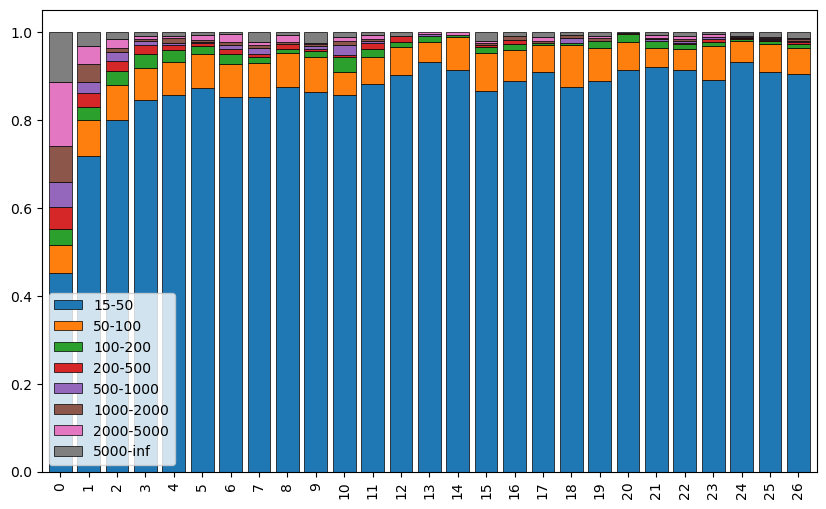

In [220]:
plt.figure(figsize = (20,10))
df2.plot.bar(stacked = True, width = 0.8, edgecolor = "black", linewidth = 0.5, figsize = (10,6), legend = False)
plt.legend()
plt.show()
#plt.savefig("sizes_rel.png", dpi = 1000)

In [203]:
df.index = list(range(1,len(df.index)+1))

In [205]:
df

,15-50,50-100,100-200,200-500,500-1000,1000-2000,2000-5000,5000-inf
1,2938,413,244,320,370,531,951,752
2,1270,145,54,57,42,73,71,60
3,657,66,26,18,17,9,16,14
4,503,43,19,13,5,3,4,6
5,410,36,13,5,3,5,2,5
6,323,29,7,2,1,2,4,3
7,279,25,7,4,3,2,6,2
8,253,23,4,2,4,2,2,7
9,214,19,2,3,0,1,4,2
10,239,22,4,1,2,1,1,7


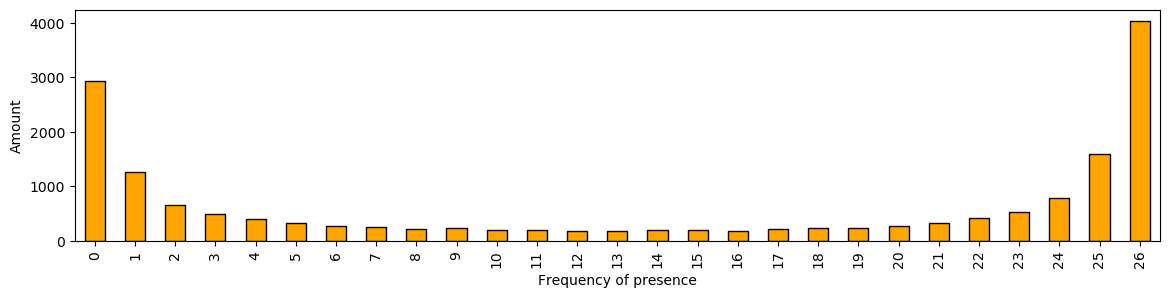

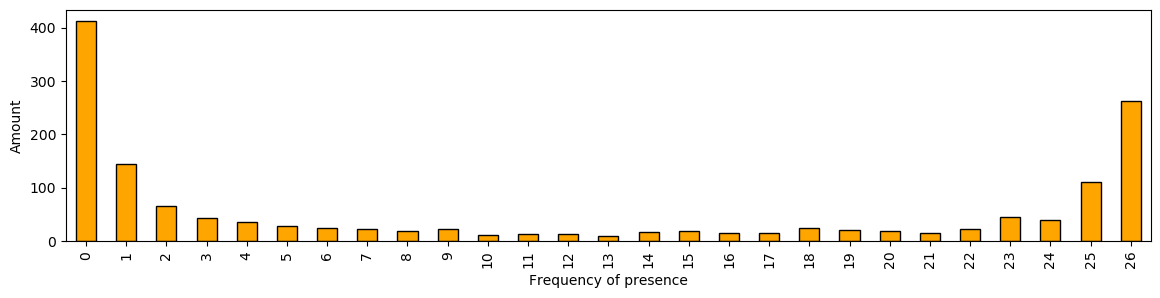

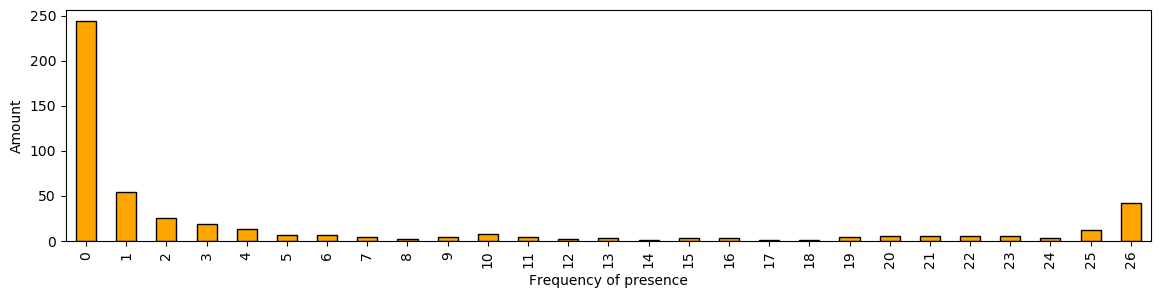

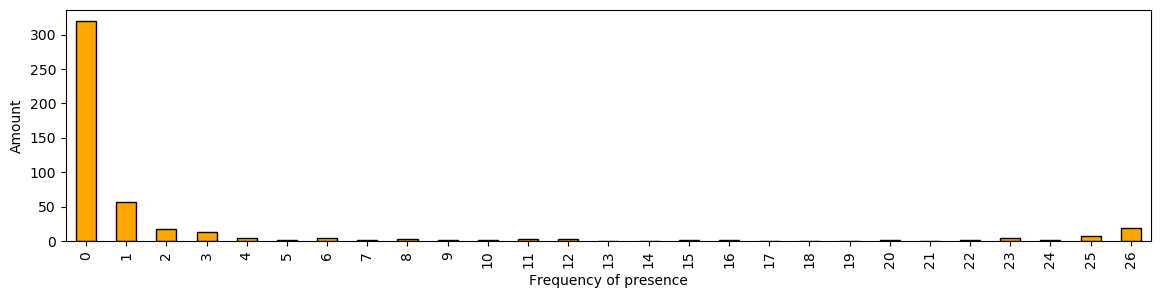

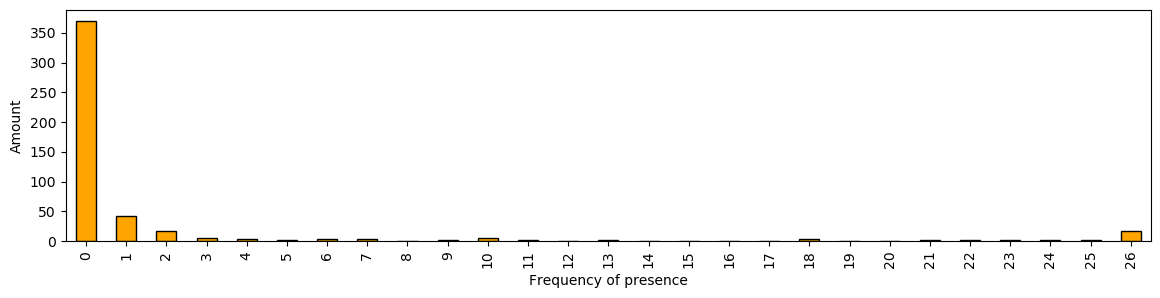

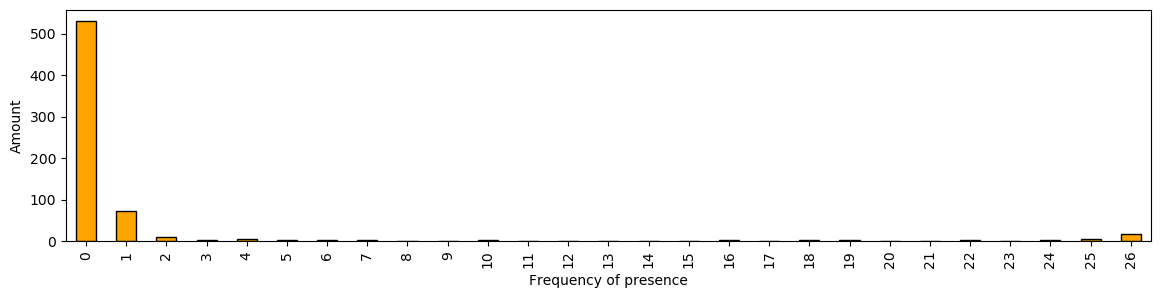

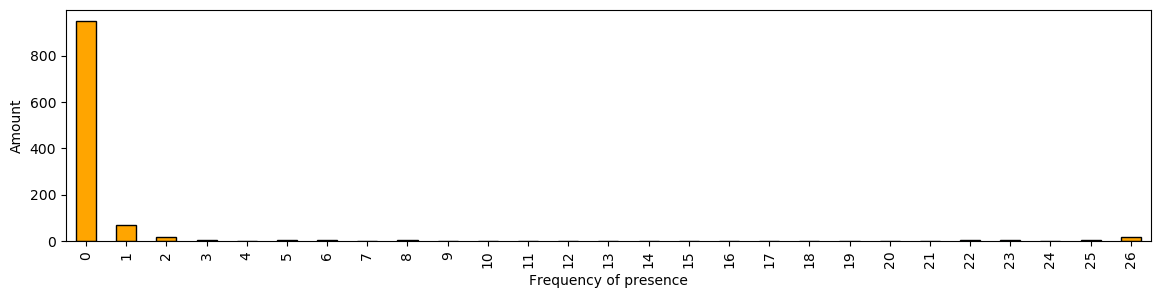

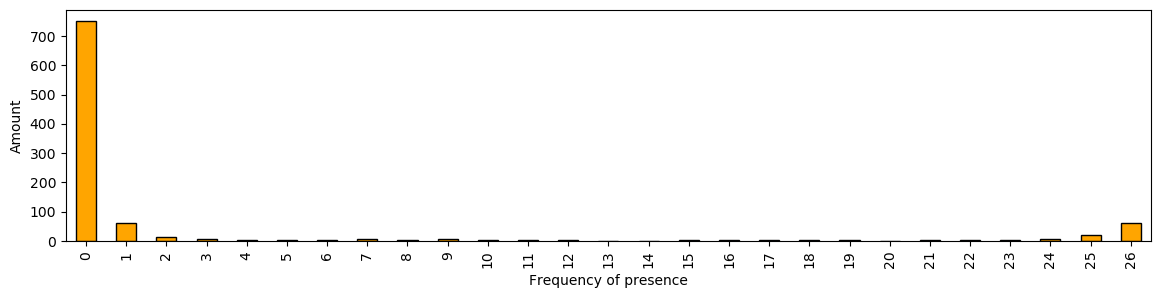

In [237]:
for x in df.columns:
    
    df[x].plot.bar(figsize = (14,3), edgecolor = "black", color = "orange")
    plt.xlabel("Frequency of presence")
    plt.ylabel("Amount")
    plt.savefig("plots/df" + str(x) + ".png", dpi = 1000)

    plt.show()

In [238]:
labels = ['SE', 'ME']

In [239]:
se = sum([len(x) for x in f])

In [240]:
me = sum([len(x) for x in all_svs])

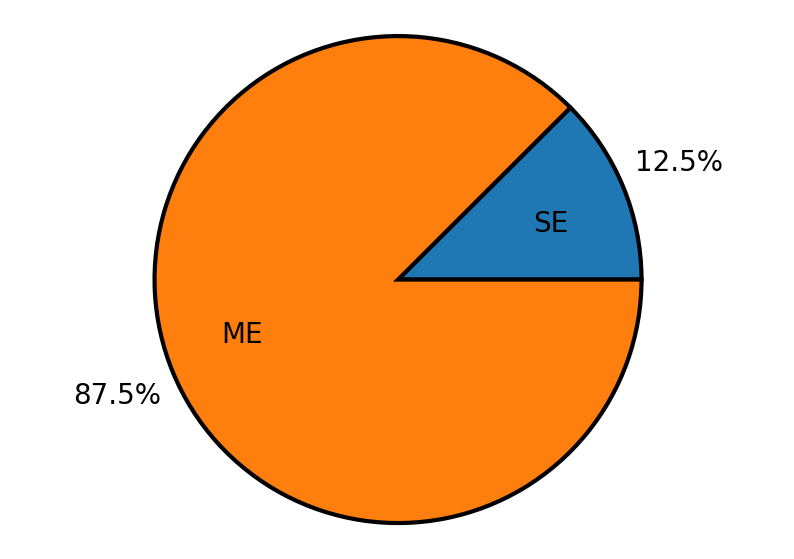

In [243]:
plt.figure(figsize=(10,7))
plt.rcParams['font.size'] = 20
plt.pie([se, me], autopct='%1.1f%%', wedgeprops={"edgecolor":"k",'linewidth': 3, 'antialiased': True},pctdistance=1.25, labeldistance=.6, labels = labels)
plt.axis('equal')
plt.savefig("plots/pieplot_seme.png", dpi = 1000)
plt.savefig("plots/pieplot_seme.svg", format = "svg")
plt.show()

# Testing

In [255]:
f2 = "/tmp/global2/svorbrugg/1001GP/scripts/github/1001GP/analysis/deconstruct/results/deconstruct/vcf/chr1.9905_Chr1.vcf"


In [261]:
dtest = []
dtest2 = []

fo = []
with open(f2) as file: 
    for line in file.readlines(): 
        if not line.startswith("#"): 
            ls = line.split()
            ref = len(ls[3]) - 1
            alt = [len(x)-1 for x in ls[4].split(",")]
            alls = [ref] + alt
            f = ls[9:]
            if not sum([x.isnumeric() for x in f]) != len(f): 
                if sum(alls) != 0:
                    fo.append([[alls[int(x)] for x in f] + [alls[0]], max(alls)])
                    dtest.append(alls)
                    dtest2.append(f)

In [262]:
fo[:10]

[[[0,
   0,
   0,
   4,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   4,
   4,
   4,
   0,
   0,
   0,
   0,
   4,
   0,
   4,
   0,
   4,
   0],
  4],
 [[1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1],
  1],
 [[1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1],
  1],
 [[1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1],
  1],
 [[1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1],
  1],
 [[1,
   1,
   1,
   1,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,

In [263]:
f = [(len([x for x in y[0] if x > y[1]*0.1]), y[1], y) for y in fo if y[1] < 100000000 and y[1] > 1000]

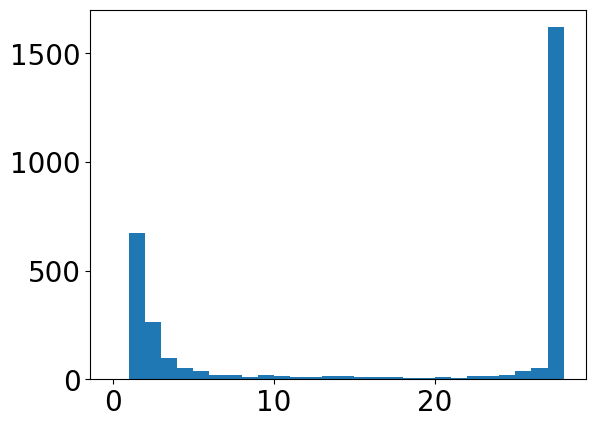

In [264]:
plt.hist([x[0] for x in f], bins = np.linspace(0,28,29))
plt.show()

In [254]:
fo

[[[1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   0,
   0,
   1,
   1,
   0,
   0,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   1],
  1],
 [[1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   1],
  1],
 [[0,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5,
   5],
  5],
 [[1,
   1,
   1,
   1,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   0,
   1,
   1,
   0],
  1],
 [[0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   0,
   1],
  1],
 [[0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   2,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,

In [260]:
fo

[[[0,
   0,
   0,
   4,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   4,
   4,
   4,
   0,
   0,
   0,
   0,
   4,
   0,
   4,
   0,
   4,
   0],
  4],
 [[1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1],
  1],
 [[1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1],
  1],
 [[1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1],
  1],
 [[1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1],
  1],
 [[1,
   1,
   1,
   1,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,